## Library

In [38]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from typing import List, Tuple, Optional
from torch import Tensor
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import torchvision
from glob import glob
from torchvision.io import read_image
from torchvision.io import ImageReadMode
import re
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from  sklearn.model_selection import train_test_split
from torchvision.transforms import v2
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.transforms import CenterCrop
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score
import seaborn as sns
import time
from datetime import timedelta
from sklearn.model_selection import KFold

## Model

In [39]:
class DNN(nn.Module):
    def __init__(self, input_size: int, output_size: int, device: torch.device) -> None:
        super(DNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_size, 200).to(device)
        self.bn1 = nn.BatchNorm1d(200).to(device)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(200, 100).to(device)
        self.bn2 = nn.BatchNorm1d(100).to(device)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(100, output_size).to(device)
        
        self._init_weights()

    def _init_weights(self) -> None:
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.normal_(param, mean=0, std=0.01)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [40]:
class LSTMCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, device: torch.device = None) -> None:
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
                
        self.weight_ih = nn.Parameter(torch.empty(4*hidden_size, input_size, device=device))
        self.weight_hh = nn.Parameter(torch.empty(4*hidden_size, hidden_size, device=device))
        
        self.bias = bias
        
        if self.bias:
            self.bias_ih = nn.Parameter(torch.empty(4*hidden_size, device=device))
            self.bias_hh = nn.Parameter(torch.empty(4*hidden_size, device=device))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        
        self.peephole_i = nn.Parameter(torch.empty(hidden_size, device=device))
        self.peephole_f = nn.Parameter(torch.empty(hidden_size, device=device))
        self.peephole_o = nn.Parameter(torch.empty(hidden_size, device=device))
        
        self._init_weights()

    def _init_weights(self) -> None:
        for param in self.parameters():
            nn.init.normal_(param, mean=0, std=0.01)
        nn.init.normal_(self.peephole_i, mean=0, std=0.01)
        nn.init.normal_(self.peephole_f, mean=0, std=0.01)
        nn.init.normal_(self.peephole_o, mean=0, std=0.01)
    
    def forward(self, input: Tensor, state: Tuple[Tensor, Tensor] = None) -> Tuple[Tensor, Tensor]:
        hx, cx = state
        gates = torch.mm(input, self.weight_ih.t()) + torch.mm(hx, self.weight_hh.t())
        if self.bias:
            gates += self.bias_ih + self.bias_hh
        
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)
        
        input_gate = torch.sigmoid(input_gate + self.peephole_i * cx)
        forget_gate = torch.sigmoid(forget_gate + self.peephole_f * cx)
        cell_gate = torch.tanh(cell_gate)
        
        cy = (forget_gate * cx) + (input_gate * cell_gate)
        
        output_gate = torch.sigmoid(output_gate + self.peephole_o * cy)
        
        hy = output_gate * torch.tanh(cy)
        return hy, cy
    
class LSTMBlock(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_cells: int, device: torch.device) -> None:
        super(LSTMBlock, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_cells = num_cells
        self.device = device
        
        self.lstm_cells = nn.ModuleList([LSTMCell(self.input_size, hidden_size, device=device)
                                         if i == 0
                                         else LSTMCell(self.hidden_size, self.hidden_size, device=device)
                                         for i in range(self.num_cells)])
        
    def forward(self, input: Tensor, state: Tuple[Tensor, Tensor]=None)->Tuple[Tensor, Tensor]:
        batch_size = input.size(0)
        
        if state is None:
            zeros = torch.zeros(batch_size, self.hidden_size, device=self.device)
            state = (zeros, zeros)
            
        hx, cx = state
        
        outputs = []
        
        seq_len = input.size(1)
        for t in range(seq_len):
            x = input[:, t, :]
            for i, lstm_cell in enumerate(self.lstm_cells):
                hx, cx = lstm_cell(x, (hx, cx))
                x = hx
            outputs.append(hx)
            
        outputs = torch.stack(outputs, dim=1)
        return outputs, (hx, cx)
    
class MultiBlockLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_blocks: int, num_cells_per_block: int, device: torch.device) -> None:
        super(MultiBlockLSTM, self).__init__()
        self.device = device
        self.blocks = nn.ModuleList([
            LSTMBlock(input_size, hidden_size, num_cells_per_block, device)
            if i == 0
            else LSTMBlock(hidden_size, hidden_size, num_cells_per_block, device)
            for i in range(num_blocks)])

    def forward(self, x: Tensor) -> Tensor:
        for block in self.blocks:
            x, _ = block(x)
        return x

In [41]:
class CNN(nn.Module):
    def __init__(self, in_channels: int, output_size: int, device: torch.device) -> None:
        super(CNN, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(in_channels, 10, kernel_size=3, stride=1, padding=1).to(device)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=2, stride=1, padding=0).to(device)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=2, stride=1, padding=0).to(device)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(30, output_size).to(device)
        
        self._init_weights()

    def _init_weights(self) -> None:
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.01)
            elif 'bias' in name:
                nn.init.normal_(param, mean=0, std=0.01)

    def forward(self, x: Tensor) -> Tensor:
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

In [42]:
class CLDNN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 cnn_out_channels: int,
                 lstm_input_size: int,
                 lstm_hidden_size: int,
                 lstm_num_blocks: int,
                 lstm_num_cells_per_block: int,
                 dnn_output_size: int,
                 device: torch.device) -> None:
        super(CLDNN, self).__init__()
        self.device = device
        self.cnn = CNN(in_channels, cnn_out_channels, device)
        self.lstm = MultiBlockLSTM(lstm_input_size, lstm_hidden_size, lstm_num_blocks, lstm_num_cells_per_block, device)
        self.dnn = DNN(lstm_hidden_size, dnn_output_size, device)
    
    def forward(self, x: Tensor) -> Tensor:
        batch_size, seq_len, channels, height, width = x.size()

        cnn_out = []
        for t in range(seq_len):
            img = x[:, t, :, :, :]
            cnn_out.append(self.cnn(img))
            
        cnn_out = torch.stack(cnn_out, dim=1)
        
        lstm_out = self.lstm(cnn_out)
        
        last_output = lstm_out[:, -1, :]
        
        out = self.dnn(last_output)
        out = torch.sigmoid(out)
        return out

## Dataset & DataLoader

In [43]:
class SeqImageDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.image_paths = [
            sorted(glob(os.path.join(dir_path, '*.jpg')), key=self.custom_sort_key)
            for dir_path in self.X
        ]
        print(f'Loaded {len(self.image_paths)} sequences')
    
    @staticmethod
    def custom_sort_key(filename):
        match = re.search(r'frame_(\d+)', filename)
        if match:
            return int(match.group(1))
        return filename  

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_sequence = [
            read_image(img_path, mode=ImageReadMode.GRAY)
            for img_path in self.image_paths[idx]
        ]
        images = torch.stack(image_sequence, dim=0)
        label = torch.tensor(self.y.iloc[idx])
        if self.transforms:
            images = self.transforms(images)
        return images, label

In [44]:
def custom_collate_fn(batch):
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)
    sequences, labels = zip(*batch)
    max_len = max([s.shape[0] for s in sequences])
    padded_seqs = []
    for seq in sequences:
        seq_len = seq.shape[0]
        if seq_len < max_len:
            last_frame = seq[-1].unsqueeze(0)
            num_repeat = max_len - seq_len
            padding = last_frame.repeat(num_repeat, 1, 1, 1)
            padded = torch.cat([seq, padding], dim=0)
        else:
            padded = seq
        padded_seqs.append(padded)
    try:
        padded_seqs = torch.stack(padded_seqs, dim=0)
    except:
        print('error')
    labels = torch.stack(labels)
    return padded_seqs, labels

In [45]:
def get_stratified_test_set(X, y, n_samples_per_class=10):
    indices_class_0 = np.where(y == 0)[0]
    indices_class_1 = np.where(y == 1)[0]

    test_indices_class_0 = np.random.choice(indices_class_0, n_samples_per_class, replace=False)
    test_indices_class_1 = np.random.choice(indices_class_1, n_samples_per_class, replace=False)

    test_indices = np.concatenate([test_indices_class_0, test_indices_class_1])

    mask = np.zeros(len(y), dtype=bool)
    mask[test_indices] = True

    X_test, X_remainder = X[mask], X[~mask]
    y_test, y_remainder = y[mask], y[~mask]

    return X_remainder, X_test, y_remainder, y_test

In [46]:
class BalancedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = labels
        self.batch_size = batch_size
        self.idx_0 = np.where(self.labels == 0)[0]
        self.idx_1 = np.where(self.labels == 1)[0]
        self.num_0 = len(self.idx_0)
        self.num_1 = len(self.idx_1)
        self.start_0 = 0
        self.start_1 = 0
        
    def __len__(self):
        return (self.num_1 + self.batch_size//2 - 1) // (self.batch_size // 2)
    
    def __iter__(self):
        
        np.random.shuffle(self.idx_0)
        np.random.shuffle(self.idx_1)
        
        max_batches = len(self)
    
        for i in range(max_batches):
            batch = []
            
            start_0 = self.start_0
            end_0 = start_0 + self.batch_size // 2
            if end_0 > self.num_0:
                batch.extend(self.idx_0[start_0: self.num_0])
                lack_0 = end_0 - self.num_0
                batch.extend(self.idx_0[:lack_0])
                self.start_0 = lack_0
            else:
                batch.extend(self.idx_0[start_0:end_0])
                self.start_0 = end_0 % self.num_0
            
            start_1 = self.start_1
            end_1 = start_1 + self.batch_size // 2
            if end_1 > self.num_1:
                batch.extend(self.idx_1[start_1: self.num_1])
                lack_1 = end_1 - self.num_1
                batch.extend(self.idx_1[:lack_1])
                self.start_1 = lack_1
            else:
                batch.extend(self.idx_1[start_1:end_1])
                self.start_1 = end_1 % self.num_1
                
            np.random.shuffle(batch)
            yield batch

In [33]:
df = pd.read_csv('data.csv')
X, y = df['img_path'], df['label']
X_remainder, X_test, y_remainder, y_test = get_stratified_test_set(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.15, stratify=y_remainder)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [36]:
transform_pipeline = v2.Compose([
    v2.Resize((300, 300)),                 
    v2.RandomHorizontalFlip(p=0.5),        
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.229]) 
])

dataset = SeqImageDataset(X_remainder, y_remainder, transforms=transform_pipeline)
dataset = SeqImageDataset(X_val, y_val, transforms=transform_pipeline)
test_dataset = SeqImageDataset(X_test, y_test, transforms=transform_pipeline)


Loaded 91 sequences
Loaded 20 sequences


In [37]:
for fold, (train_idx, test_idx) in enumerate(kf.split(train_dataset)):
    print(test_idx)

[ 0  4 10 12 18 28 33 35 45 47 50 53 58 66 68 74]
[ 5  7  9 16 22 30 31 34 39 40 44 49 54 62 65 73]
[ 3  6  8 13 17 19 25 36 38 42 55 61 64 70 76]
[11 15 24 26 27 32 41 43 46 48 56 57 69 72 75]
[ 1  2 14 20 21 23 29 37 51 52 59 60 63 67 71]


In [13]:
batch_size = 8
train_sampler = BalancedBatchSampler(y_train, batch_size)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [15]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, kernel_size, stride, out_channels, rnn_n_layers, rnn_type, bidirectional, w_std, padding):
        super(CRNN, self).__init__()
        
        self.kernel_size = kernel_size
        self.stride = stride
        self.out_channels = out_channels
        self.rnn_n_layers = rnn_n_layers
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        self.padding = padding

        # Define RNN layer
        if rnn_type == 'simple':
            rnn_cell = nn.RNN
        elif rnn_type == 'lstm':
            rnn_cell = nn.LSTM
        elif rnn_type == 'gru':
            rnn_cell = nn.GRU
        
        # Note: input_size should be `n_in_features`, not `kernel_size`
        self.rnn = rnn_cell(input_size=90000,  # Số lượng đặc trưng (features) của mỗi bước thời gian
                            hidden_size=out_channels, 
                            num_layers=rnn_n_layers, 
                            bidirectional=bidirectional, 
                            batch_first=True)

    def forward(self, x):
        # x shape: [batch, time-steps, features] or [batch, time-steps, features, 1]
        if x.dim() == 3:
            x = x.unsqueeze(3)
        
        batch_size, time_steps, n_in_features, _ = x.size()
        
        # Extract patches
        x = x.unfold(dimension=1, size=self.kernel_size, step=self.stride)
        x = x.contiguous().view(batch_size, -1, self.kernel_size * n_in_features)
        
        # Reshape for RNN
        time_steps_after_stride = x.size(1)
        x = x.view(batch_size * time_steps_after_stride, self.kernel_size, n_in_features)
        
        # Pass through RNN
        x, _ = self.rnn(x)
        
        # Select the last time-step for each sequence output
        if self.bidirectional:
            x = torch.cat((x[:, -1, :self.out_channels], x[:, 0, self.out_channels:]), dim=-1)
        else:
            x = x[:, -1, :]
        
        # Reshape to [batch, time_steps, out_channels]
        out_channels = 2 * self.out_channels if self.bidirectional else self.out_channels
        x = x.view(batch_size, time_steps_after_stride, out_channels)
        
        return x

# Giả sử đầu vào có shape [batch, time-steps, features]


# Tạo tensor đầu vào ngẫu nhiên với shape [batch, time-steps, features]
tensor = next(iter(train_loader))[0]
*start_dims, height, width = tensor.shape
input = tensor.view(*start_dims, height * width)
input = input.permute(0, 1, 3, 2)

# Khởi tạo mô hình CRNN với các tham số tương ứng
model = CRNN(kernel_size=3, stride=1, out_channels=200, rnn_n_layers=2, 
             rnn_type='lstm', bidirectional=True, w_std=0.02, padding='same')

# Chạy forward pass với mô hình
output_tensor = model(input)

# In shape của output
print(output_tensor.shape)


torch.Size([8, 168, 400])


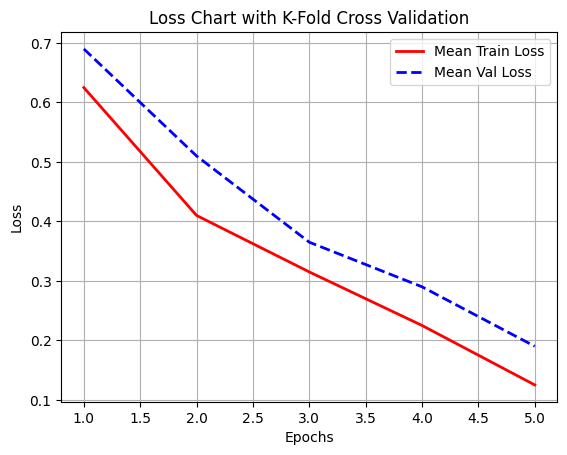

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử bạn đã có các giá trị loss cho mỗi fold
train_losses = [
    [0.6, 0.4, 0.3, 0.2, 0.1],  # Loss của fold 1
    [0.65, 0.42, 0.33, 0.25, 0.15],  # Loss của fold 2
    # Thêm các loss của các fold khác
]

val_losses = [
    [0.7, 0.5, 0.35, 0.28, 0.18],  # Validation Loss của fold 1
    [0.68, 0.52, 0.38, 0.30, 0.20],  # Validation Loss của fold 2
    # Thêm các loss của các fold khác
]

# Số lượng fold
k = len(train_losses)

# Số lượng epoch
epochs = range(1, len(train_losses[0]) + 1)

# # Vẽ loss của từng fold
# for i in range(k):
#     plt.plot(epochs, train_losses[i], label=f'Train Fold {i+1}')
#     plt.plot(epochs, val_losses[i], label=f'Val Fold {i+1}', linestyle='--')

# Tính trung bình loss qua các fold
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# Vẽ trung bình
plt.plot(epochs, mean_train_loss, label='Mean Train Loss', color='red', linewidth=2)
plt.plot(epochs, mean_val_loss, label='Mean Val Loss', color='blue', linewidth=2, linestyle='--')

# Tùy chỉnh biểu đồ
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Chart with K-Fold Cross Validation')
plt.legend()
plt.grid(True)
plt.show()


## Training & Evaluating

In [28]:
def train(model, train_loader, val_loader, epochs, optimizer, loss_fn, device):
    model.to(device)
    train_losses = []
    val_losses = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                y_hat = model(X)
                loss = loss_fn(y_hat, y)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        
        epochs_left = epochs - (epoch + 1)
        eta_seconds = epochs_left * epoch_duration
        eta = str(timedelta(seconds=int(eta_seconds)))
        
        print(f'Epoch: {epoch + 1:3d}/{epochs:<3d} | '
            f'Train Loss: {train_losses[-1]:<10.4f} | '
            f'Val Loss: {val_losses[-1]:<10.4f} | '
            f'Epoch Time: {epoch_duration:<7.2f}s | '
            f'ETA: {eta:<8}')
    
    total_time = time.time() - start_time
    print(f'Total training time: {str(timedelta(seconds=int(total_time)))}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('loss_chart.png')
    print("Loss chart saved as 'loss_chart.png'")
    
    return train_losses, val_losses

In [29]:
def evaluate(model, data_loader, device, class_names):
    model.eval()
    all_preds = []
    all_targets = []
    misclassified_indices = []
    
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            
            start_idx = batch_idx * data_loader.batch_size
            batch_misclassified = (predicted != y).nonzero(as_tuple=True)[0]
            misclassified_indices.extend(start_idx + batch_misclassified.cpu().numpy())
    
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    
    acc = accuracy_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')
    
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.jpg')
    plt.close()
    
    return {
        'accuracy': acc,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'misclassified_indices': misclassified_indices
    }

In [25]:
in_channels = 1
cnn_output_size = 300
lstm_input_size = cnn_output_size
lstm_hidden_size = 200
lstm_num_blocks = 10
lstm_num_cells_per_block = 10
dnn_output_size = 2
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = CLDNN(
    in_channels=in_channels,
    cnn_out_channels=cnn_output_size,
    lstm_input_size=lstm_input_size, 
    lstm_hidden_size=lstm_hidden_size, 
    lstm_num_blocks=lstm_num_blocks,
    lstm_num_cells_per_block=lstm_num_cells_per_block,
    dnn_output_size=dnn_output_size,
    device=device)
optimizer = AdamW(model.parameters(), lr = 0.0001)
loss_fn = CrossEntropyLoss(weight=class_weights)
epochs = 100

### Training

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, epochs, optimizer, loss_fn, device)

### Loss Chart

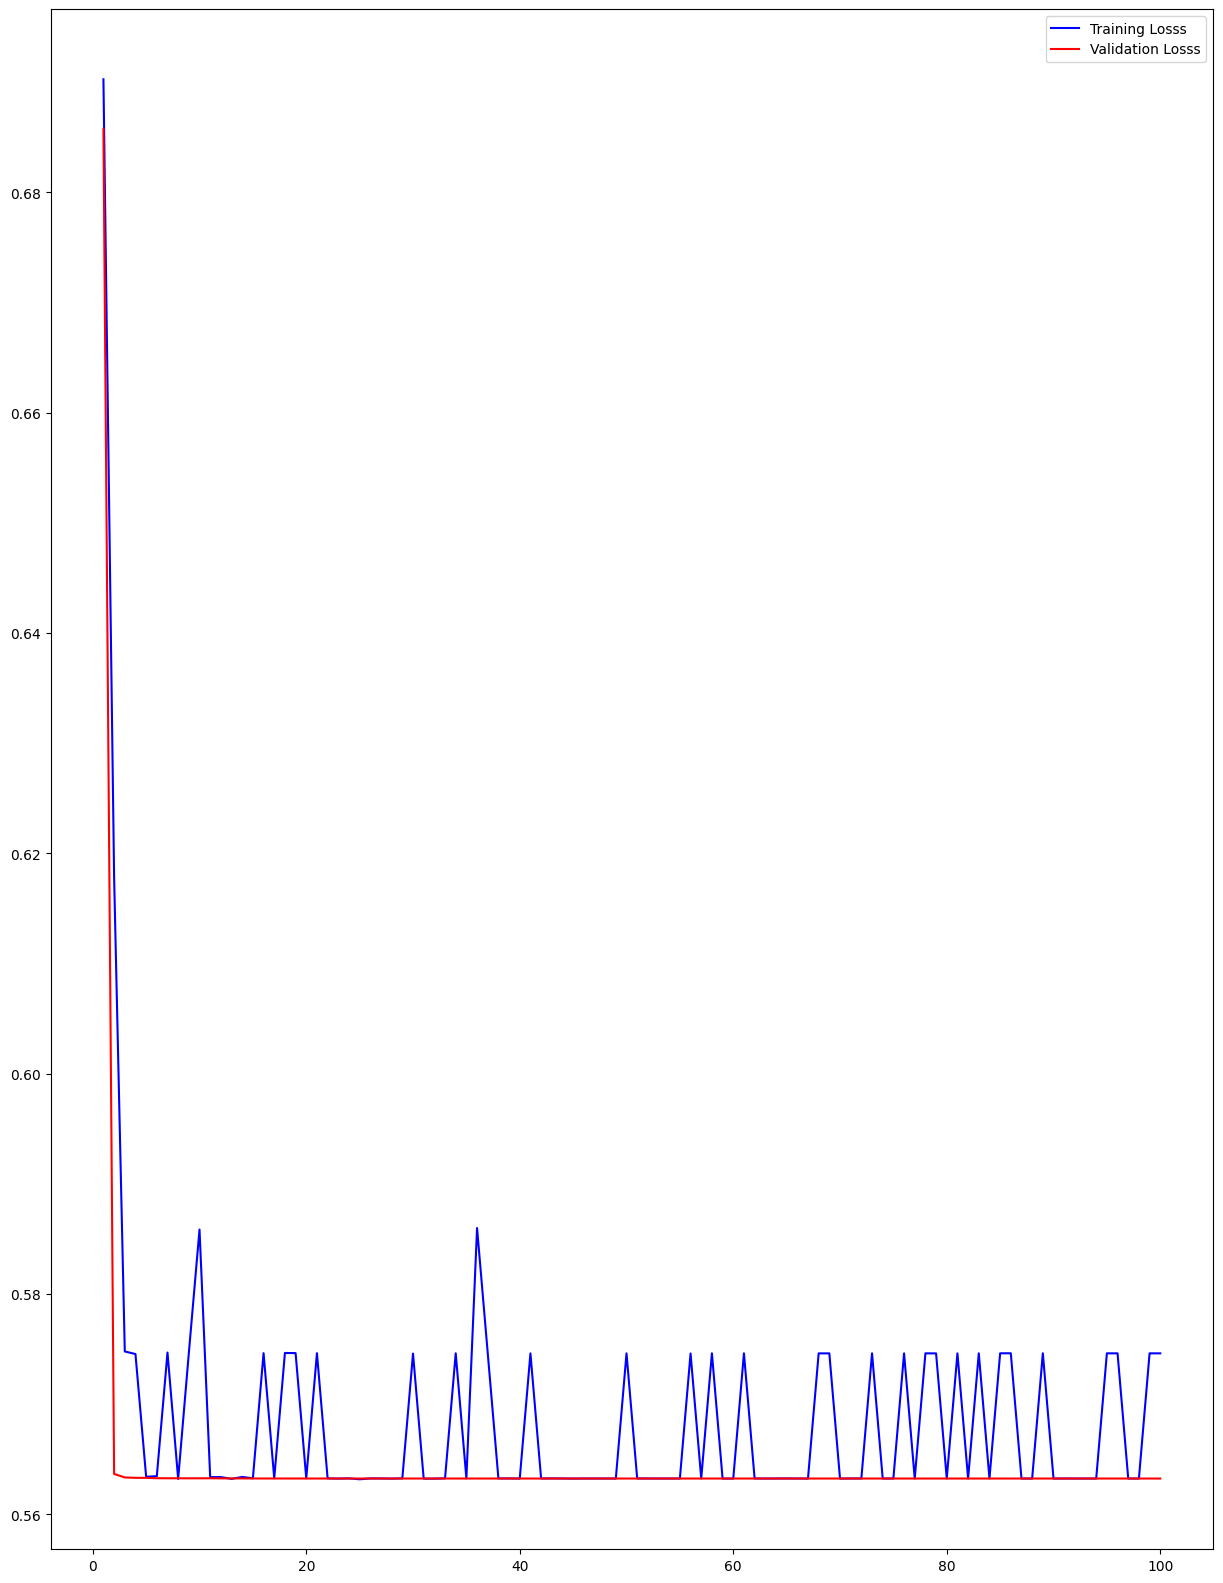

In [ ]:
plt.figure(figsize=(15, 20))
plt.plot(range(1, epochs+1), train_losses, c='blue', label='Training Losss')
plt.plot(range(1, epochs+1), val_losses, c='red', label='Validation Losss')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluating and Confusion Matrix

In [ ]:
class_names = ['0','1']
results = evaluate(model, data_loader, device, class_names)

print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1-score: {results['f1_score']:.4f}")
print(f"Number of misclassified samples: {len(results['misclassified_indices'])}")
plt.imshow('confusion_matrix.jpg')

## Saving Model

In [ ]:
torch.save(model.state_dict(),'weight/model_batch_sampler_class_weight.pt')

In [61]:
epoch = 102
epochs = 10
train_losses = [0.0]
val_losses = [1.0]
epoch_duration = 10.0
eta = 9

In [64]:
print(f'Epoch: {epoch + 1:3d}/{epochs:<3d} | '
      f'Train Loss: {train_losses[-1]:<10.4f} | '
      f'Val Loss: {val_losses[-1]:<10.4f} | '
      f'Epoch Time: {epoch_duration:<7.2f}s | '
      f'ETA: {eta:<8}')

Epoch: 103/10  | Train Loss: 0.0000     | Val Loss: 1.0000     | Epoch Time: 10.00  s | ETA: 9       
